# NumPy vs PyTorch CNN Comparison

Side-by-side comparison of:
- **NumPy CNN**: From-scratch, educational, slow
- **PyTorch CNN**: Production-ready, fast

Both use the same architecture!


In [1]:
# Setup
import sys
sys.path.insert(0, '..')

import numpy as np
import torch
import matplotlib.pyplot as plt
import time

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch device: {device}")

%matplotlib inline


PyTorch device: cpu


## 1. Load Data


In [2]:
from src.utils import load_mnist

# Small subset for fair timing comparison
X_train, y_train, X_test, y_test = load_mnist('../mnist_dataset', subset_size=(1000, 200))


Loaded MNIST: 1000 training, 200 test samples
Image shape: (1, 28, 28) (channels, height, width)


## 2. Train NumPy CNN


In [3]:
from src.cnn import CNN

print("Training NumPy CNN...")
numpy_model = CNN(input_shape=(1, 28, 28), num_classes=10)

start = time.time()
numpy_history = numpy_model.fit(
    X_train, y_train, 
    epochs=3, 
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=True
)
numpy_time = time.time() - start
print(f"\n NumPy training time: {numpy_time:.1f}s")


Training NumPy CNN...


Epoch 1/3: 100%|██████████| 32/32 [00:10<00:00,  3.11it/s, loss=1.5922, acc=0.4640]


Epoch 1/3 - Loss: 1.5922 - Acc: 0.4640 - Val Loss: 0.5685 - Val Acc: 0.8450 - LR: 0.001000


Epoch 2/3: 100%|██████████| 32/32 [00:10<00:00,  3.17it/s, loss=0.7367, acc=0.7600]


Epoch 2/3 - Loss: 0.7367 - Acc: 0.7600 - Val Loss: 0.3695 - Val Acc: 0.9250 - LR: 0.001000


Epoch 3/3: 100%|██████████| 32/32 [00:10<00:00,  2.99it/s, loss=0.5132, acc=0.8550]


Epoch 3/3 - Loss: 0.5132 - Acc: 0.8550 - Val Loss: 0.2282 - Val Acc: 0.9350 - LR: 0.001000

 NumPy training time: 33.6s


## 3. Train PyTorch CNN


In [4]:
from pytorch.cnn_pytorch import CNNPyTorch, train_pytorch_model, create_data_loaders

train_loader, test_loader = create_data_loaders(X_train, y_train, X_test, y_test, batch_size=32)

print("Training PyTorch CNN...")
pytorch_model = CNNPyTorch(input_channels=1, num_classes=10).to(device)

start = time.time()
pytorch_history = train_pytorch_model(
    pytorch_model, train_loader, 
    val_loader=test_loader,
    epochs=3,
    device=device,
    verbose=True
)
pytorch_time = time.time() - start
print(f"\n PyTorch training time: {pytorch_time:.1f}s")


Training PyTorch CNN...
Epoch 1/3 - Loss: 1.4469 - Acc: 0.5610 - Val Loss: 1.3245 - Val Acc: 0.6700
Epoch 2/3 - Loss: 0.7650 - Acc: 0.8420 - Val Loss: 0.4155 - Val Acc: 0.9400
Epoch 3/3 - Loss: 0.5153 - Acc: 0.9060 - Val Loss: 0.3065 - Val Acc: 0.9500

 PyTorch training time: 4.5s


## 4. Compare Results


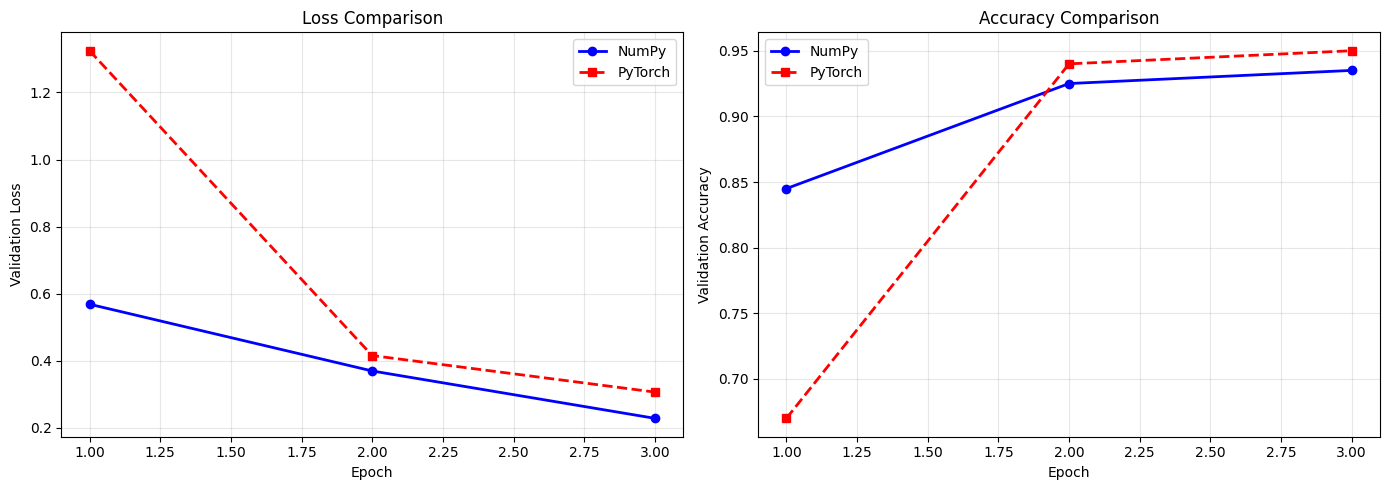

In [5]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, 4)

# Loss
axes[0].plot(epochs, numpy_history['val_loss'], 'b-o', label='NumPy', linewidth=2)
axes[0].plot(epochs, pytorch_history['val_loss'], 'r--s', label='PyTorch', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Loss')
axes[0].set_title('Loss Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs, numpy_history['val_accuracy'], 'b-o', label='NumPy', linewidth=2)
axes[1].plot(epochs, pytorch_history['val_accuracy'], 'r--s', label='PyTorch', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy')
axes[1].set_title('Accuracy Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 5. Summary Table


In [7]:
from pytorch.cnn_pytorch import evaluate_pytorch_model

# Final evaluation
numpy_loss, numpy_acc = numpy_model.evaluate(X_test, y_test)
pytorch_loss, pytorch_acc = evaluate_pytorch_model(pytorch_model, test_loader, device)

# Summary
print("\n" + "=" * 60)
print("COMPARISON SUMMARY")
print("=" * 60)
print(f"\n{'Metric':<25} {'NumPy':<15} {'PyTorch':<15}")
print("-" * 55)
print(f"{'Training Time':<25} {numpy_time:.1f}s{'':<10} {pytorch_time:.1f}s")
print(f"{'Test Accuracy':<25} {numpy_acc:.2%}{'':<10} {pytorch_acc:.2%}")
print(f"{'Test Loss':<25} {numpy_loss:.4f}{'':<10} {pytorch_loss:.4f}")
print(f"{'Speedup':<25} {'1x':<15} {numpy_time/pytorch_time:.0f}x faster")
print("=" * 60)



COMPARISON SUMMARY

Metric                    NumPy           PyTorch        
-------------------------------------------------------
Training Time             33.6s           4.5s
Test Accuracy             93.50%           95.00%
Test Loss                 0.2282           0.3065
Speedup                   1x              7x faster


## 5. Inference Speed Benchmark

Compare inference latency (time per prediction) between NumPy and PyTorch.


In [8]:
from pytorch.cnn_pytorch import benchmark_pytorch_inference

# Prepare sample inputs
sample_np = X_test[:32]  # Batch of 32 images
sample_torch = torch.FloatTensor(X_test[:32])

# Benchmark NumPy inference
numpy_times = []
for _ in range(50):
    start = time.time()
    _ = numpy_model.predict(sample_np)
    numpy_times.append(time.time() - start)
numpy_inf_ms = np.mean(numpy_times) * 1000

# Benchmark PyTorch inference
pytorch_stats = benchmark_pytorch_inference(pytorch_model, sample_torch, n_runs=100, device=device)

print("Inference Benchmark (batch of 32 images):")
print("=" * 50)
print(f"{'Method':<20} {'Total (ms)':<15} {'Per Image (ms)'}")
print("-" * 50)
print(f"{'NumPy':<20} {numpy_inf_ms:<15.2f} {numpy_inf_ms/32:.3f}")
print(f"{'PyTorch':<20} {pytorch_stats['mean_ms']:<15.2f} {pytorch_stats['per_sample_ms']:.3f}")
print("-" * 50)
print(f"PyTorch is {numpy_inf_ms/pytorch_stats['mean_ms']:.1f}x faster at inference")


Inference Benchmark (batch of 32 images):
Method               Total (ms)      Per Image (ms)
--------------------------------------------------
NumPy                111.36          3.480
PyTorch              10.30           0.322
--------------------------------------------------
PyTorch is 10.8x faster at inference


## Conclusions

| Aspect | NumPy CNN | PyTorch CNN |
|--------|-----------|-------------|
| **Speed** | slow | Fast (optimized) |
| **Accuracy** | Same | Same |
| **Use Case** | Learning | Production |
| **GPU Support** | ❌ | ✅ |
| **Transparency** | Full control | Black box |

**Key Insight**: Both achieve almost similar accuracy, proving our NumPy implementation is correct!
